In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns
import pickle

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## **Loading dataset**

In [3]:
df = pd.read_csv(r'C:\Users\zamir\zamir\data analysis\customer churn analysis\Telco-Customer-Churn.csv')

Droping the uncessesary columns

In [4]:
df = df.drop(columns = ['customerID'])

In [5]:
# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = ['SeniorCitizen'] + categorical_cols

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# printing unique values in each column
for col in df.columns:
    if col not in numerical_features:
        print(col, df[col].unique())
        print('-'*50)

gender ['Female' 'Male']
--------------------------------------------------
SeniorCitizen [0 1]
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet service']
--------------------------------------------------
TechSupport ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingTV ['No' 'Yes' 'No internet 

Handeling missing values and changing columns datatypes.

In [6]:
df['TotalCharges'] = df['TotalCharges'].replace({" ": "0.0"})
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [7]:
# checking target varaible imbalance
print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


## **Insights**
1. CustomerID is removed as it was not needed for the modeling.
2. No missing values in the dataset.
3. Change the incorrect datatype for the TotalCharges column from object -> float.
4. Class imbalance identified in the target column.

## **EDA**

In [8]:
print(df.describe())

       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2279.734304
std         0.368612    24.559481       30.090047   2266.794470
min         0.000000     0.000000       18.250000      0.000000
25%         0.000000     9.000000       35.500000    398.550000
50%         0.000000    29.000000       70.350000   1394.550000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000


**Numerical feature analysis**

Understanding the distribution of the numerical features

1. Function for histogram visualization

In [9]:
def plot_histogram(df, numerical_features):
    for feature in numerical_features:
        print(feature, df[feature].skew())
        plt.figure(figsize = (5, 3))
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribution of {feature}')

        # Calculate the mean and median values for the columns
        col_mean = df[feature].mean()
        col_median = df[feature].median()

        # Add vertical lines for mean and median
        plt.axvline(col_mean, color='red', linestyle='--', linewidth=1, label='Mean')
        plt.axvline(col_median, color='blue', linestyle='-', linewidth=1, label='Median')
        plt.legend()

        plt.show()

tenure 0.2395397495619829


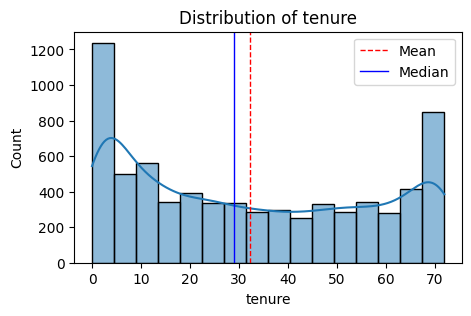

MonthlyCharges -0.22052443394398033


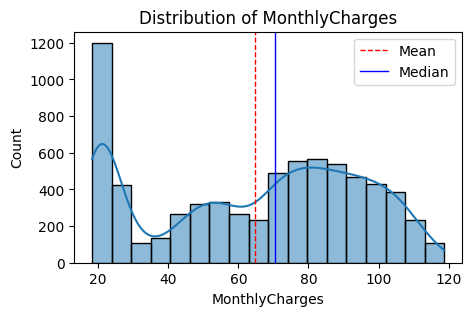

TotalCharges 0.963234654832277


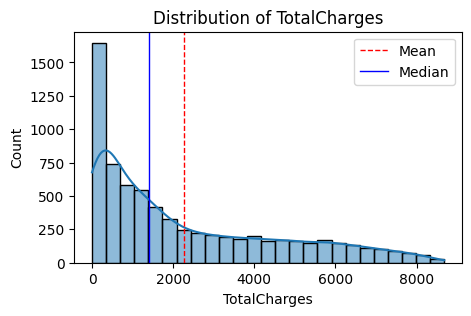

In [10]:
plot_histogram(df, numerical_features)

2. Function for boxplot visualization

In [11]:
def plot_boxplot(df, numerical_features):
    for features in numerical_features:
        plt.figure(figsize=(5, 3))
        sns.boxplot(x=df[features])
        plt.title(f'Boxplot of {features}')
        plt.ylabel(features)
        plt.show()

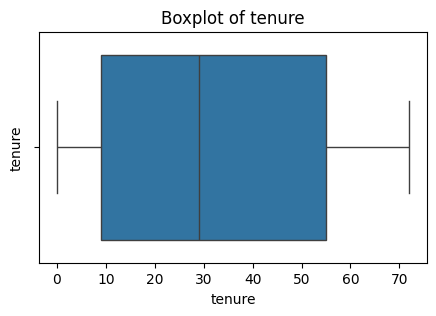

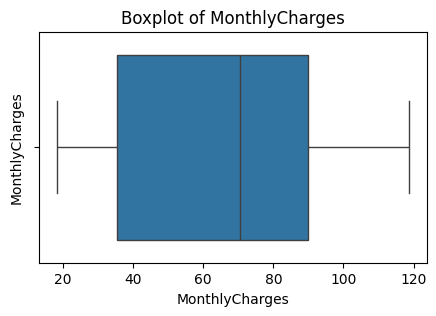

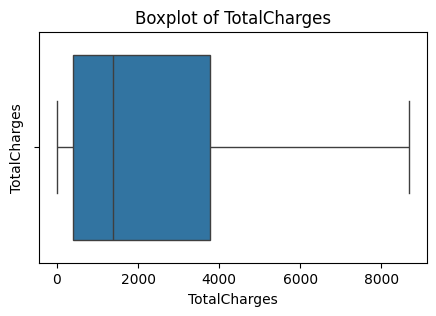

In [12]:
plot_boxplot(df, numerical_features)

Correlation Heatmap for numerical columns

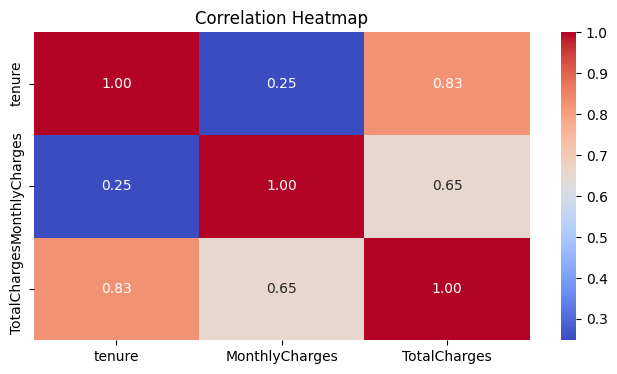

In [13]:
# Correlation Heatmap for numerical columns
plt.figure(figsize=(8, 4))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**Categorical feature analysis**

count plot for categorical columns

1. Found imbalance in the target column (churn)

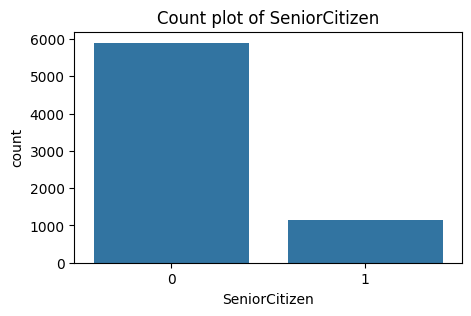

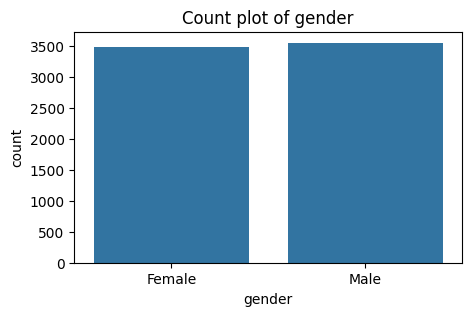

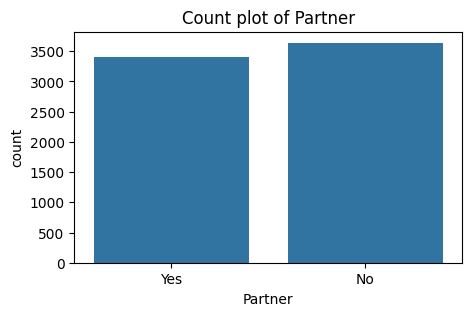

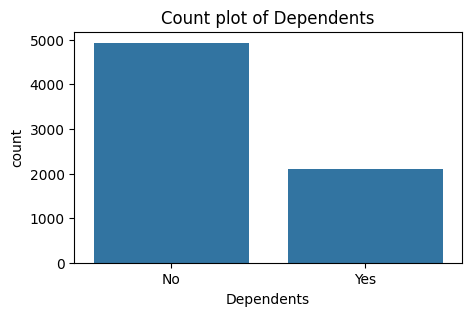

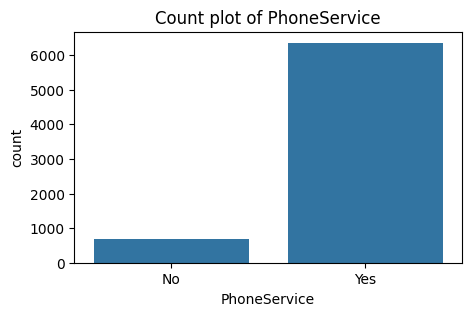

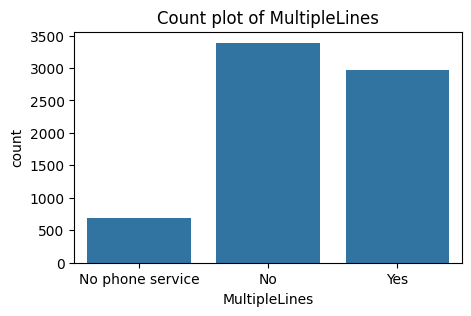

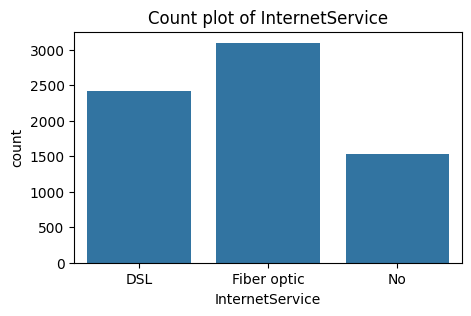

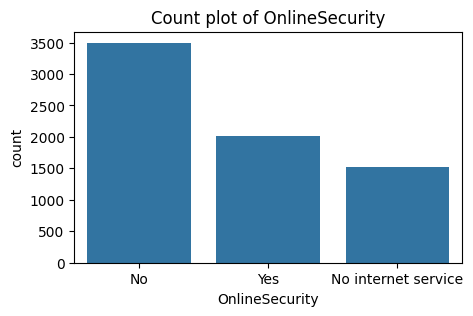

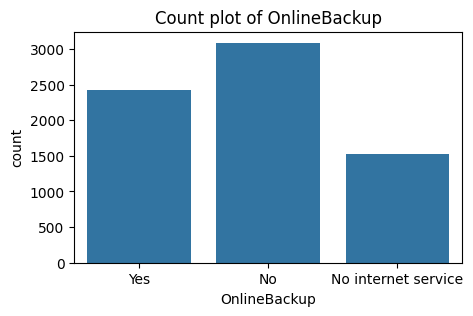

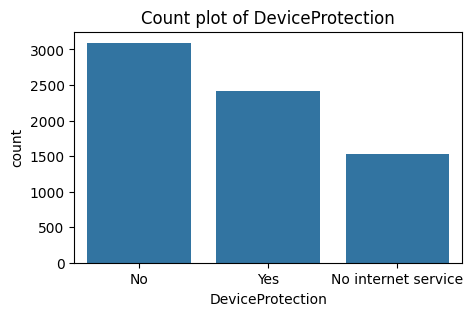

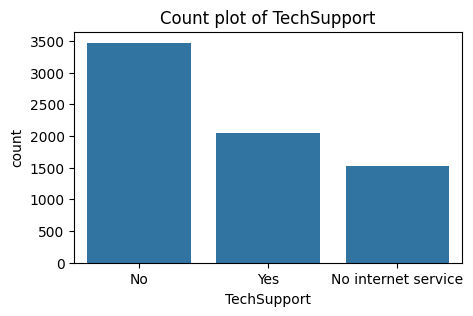

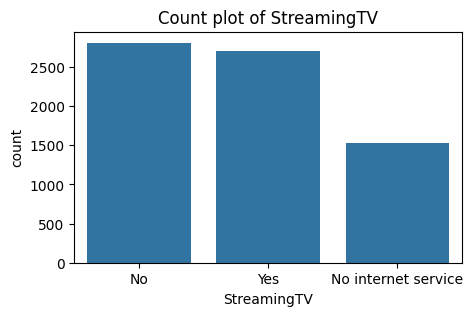

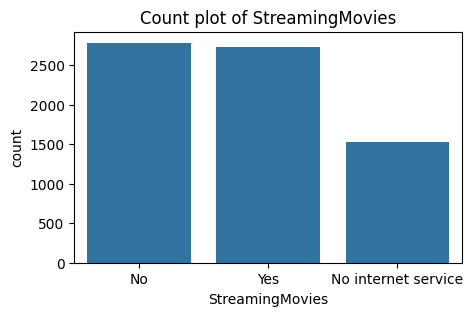

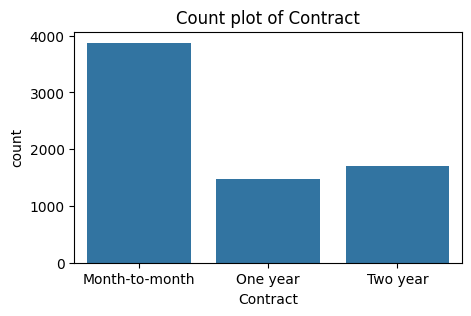

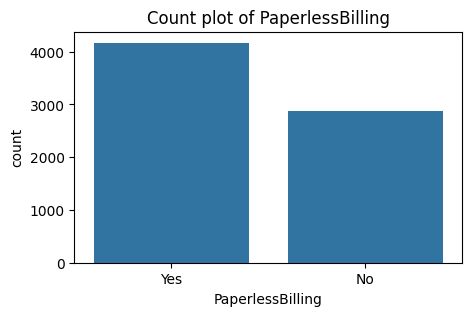

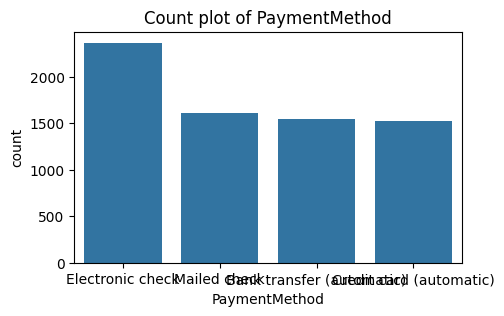

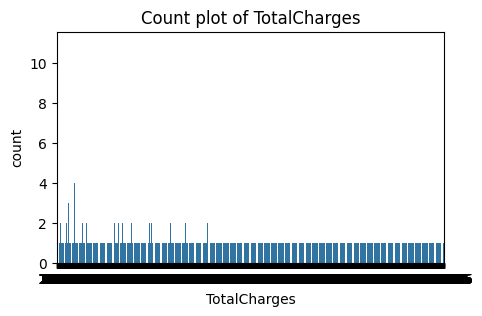

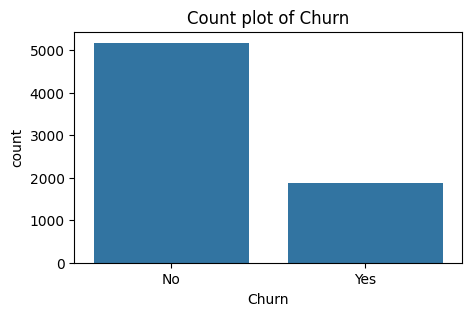

In [14]:
for col in categorical_cols:
    plt.figure(figsize=(5, 3))
    sns.countplot(x=df[col])
    plt.title(f'Count plot of {col}')
    plt.show()

# **Data Preprocessing**

label encoding of target column

In [15]:
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})
df.head(3)

C:\Users\zamir\AppData\Local\Temp\ipykernel_9616\3496869955.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1


Label encoding of categorical columns

In [16]:
# initializing label encoder
encoders = {}

# apply label encoding and store the encoder for each column
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# save the encoders to a file
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

1. Split the dataset into train and test part
2. And then apply SMOTE

Training and test data split

In [17]:
X = df.drop(columns=['Churn'])
y = df['Churn']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
print(y_train.value_counts())

Churn
0    4138
1    1496
Name: count, dtype: int64


Synthetic Minority Oversampling (SMOTE)

1. Used to balance the target column (training part of the dataset)

In [20]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [21]:
print(y_train_smote.value_counts())

Churn
0    4138
1    4138
Name: count, dtype: int64


**Model Training**

Training with default hyperparameters

In [22]:
# dictionary of models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
}

In [23]:
# Dictionary to store cross validation scores
cv_scores = {}

# Perform 5-fold cross-validation for each model
for model_name, model in models.items():
    print(f"Training {model_name} with default hyperparameters")
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
    cv_scores[model_name] = scores
    print(f"{model_name} Cross-Validation Scores: {np.mean(scores):.2f}")
    print('-' * 50)

Training Decision Tree with default hyperparameters
Decision Tree Cross-Validation Scores: 0.78
--------------------------------------------------
Training Random Forest with default hyperparameters
Random Forest Cross-Validation Scores: 0.84
--------------------------------------------------
Training XGBoost with default hyperparameters
XGBoost Cross-Validation Scores: 0.83
--------------------------------------------------
Training KNN with default hyperparameters
KNN Cross-Validation Scores: 0.77
--------------------------------------------------


Random forest gives the highest accurary than the other models

In [24]:
rfc = RandomForestClassifier(random_state=42)

pipeline = ImbPipeline([
    ('scaler', MinMaxScaler()),     # Normalize data
    ('smote', SMOTE(random_state=42)),  # Handle imbalance
    ('clf', RandomForestClassifier(random_state=42))  # Classifier
])

# define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# fit on SMOTE data
grid_search.fit(X_train_smote, y_train_smote)

# best model and parameters
print("Best Parameters:", grid_search.best_params_)
best_rfc = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [25]:
print(y_test.value_counts())

Churn
0    1036
1     373
Name: count, dtype: int64


# **Model evaluation**

In [26]:
y_test_pred = best_rfc.predict(X_test)
print("Test Accuracy:\n", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Test Accuracy:
 0.7714691270404542
Confusion Matrix:
 [[854 182]
 [140 233]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1036
           1       0.56      0.62      0.59       373

    accuracy                           0.77      1409
   macro avg       0.71      0.72      0.72      1409
weighted avg       0.78      0.77      0.78      1409



In [27]:
X.columns.tolist()

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

In [28]:
# Save the trained model
model_data = {"model": best_rfc, "features_names": X.columns.tolist()}

with open('customer_churn_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

In [29]:
# load the saved model and features names
with open('customer_churn_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

loaded_model = model_data["model"]
feature_name = model_data["features_names"]

In [30]:
print(loaded_model)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, random_state=42)


In [31]:
for x in feature_name:
    print(x)

gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges


In [32]:
# Taking unknown data for prediction
input_data = {
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 1,
    "PhoneService": "No",
    "MultipleLines": "No phone service",
    "InternetService": "DSL",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "No",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 29.85,
    "TotalCharges": 29.85
}

In [33]:
input_data_df = pd.DataFrame([input_data])

with open('label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

print(input_data_df.head()) # input data encoding

# encode categorical features using saved encoders
for col, encoder in encoders.items():
    if col in input_data_df.columns:
        input_data_df[col] = encoder.transform(input_data_df[col])

   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   

  PaperlessBilling     PaymentMethod  MonthlyCharges  TotalCharges  
0              Yes  Electronic check           29.85         29.85  


In [34]:
# input data after encoding
input_data_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,75


In [35]:
# make a new prediction
prediction = loaded_model.predict(input_data_df)
pred_prob = loaded_model.predict_proba(input_data_df)

In [36]:
# results
print(prediction)
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Prediction Probability: {pred_prob}")

[0]
Prediction: No Churn
Prediction Probability: [[0.54749377 0.45250623]]
